# Fraud Patterns and Impact in Canada
**Trends, Geography, Demographics and Financial losses**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
from statsmodels.tsa import stattools, seasonal, arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf, plot_predict
import statsmodels.api as sm
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.signal import find_peaks
import seaborn as sns
from scipy.stats import chi2_contingency
import unidecode

# DATA PRE-PROCESS
Run before you run in any selected topic belows.

In [4]:
data = pd.read_csv('fraud_data_2021-01-01-to-2024-06-30.csv', )

In [19]:
def data_cleaning_4_raw(data):
    # English Column Extract
    data.columns = [unidecode.unidecode(col) for col in data.columns]

    data = data[[
        "Numero d'identification / Number ID",
        'Date Received / Date recue',
        'Complaint Received Type', 'Country', 'Pays',
        'Province/State',
        'Fraud and Cybercrime Thematic Categories',
        'Solicitation Method', 'Gender','Language of Correspondence',
        "Victim Age Range / Tranche d'age des victimes", 'Complaint Type',
        'Number of Victims / Nombre de victimes',
        'Dollar Loss /pertes financieres']]

    # Rename columns' name in english
    data.rename(columns={
        "Numero d'identification / Number ID":"Number_ID",
        'Date Received / Date recue':"Date_Received",
        'Fraud and Cybercrime Thematic Categories':"Fraud_and_Cybercrime_Thematic_Categories",
        "Victim Age Range / Tranche d'age des victimes":"Victim_Age_Range",
        'Number of Victims / Nombre de victimes':'Number_of_Victims',
        'Dollar Loss /pertes financieres':'Dollar_Loss',
        }, inplace=True)

    # Get Canada's Data only
    data = data.loc[data['Country'].str.contains("Canada", na=False)]
    # Remove Provence = 'California':
    data = data[data['Province/State']!= "California"]
    data.reset_index(inplace=True, drop=True)

    # Columns' type modify
    data['Dollar_Loss'] = data['Dollar_Loss'].map(lambda x: float(re.sub('[$,]','',x)))
    data['Date_Received'] = pd.to_datetime(data['Date_Received'])


    data[data['Province/State'] != 'California']
    return data

clean_data = data_cleaning_4_raw(data)

/var/folders/21/_661td0j1cddth8c88wkc_880000gn/T/ipykernel_99624/348637590.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={


# CYBERCRIME TREND ANALYSIS

## PreProcess Trend Data

In [20]:
clean_data.set_index('Date_Received', inplace=True)

In [21]:
from itertools import count
group_clean_data = clean_data.groupby(pd.Grouper(freq='W')).agg({'Number_ID':'count', 'Dollar_Loss':'sum'})
group_clean_data.rename(columns={'Number_ID':'Cases_Number'}, inplace=True)
group_clean_data.head()

,Cases_Number,Dollar_Loss
Date_Received,,
2021-01-03,93,72269.08
2021-01-10,1472,3464635.85
2021-01-17,1432,3550356.61
2021-01-24,1775,1892402.86
2021-01-31,1816,3405018.22


## Data Visualization


#### Visulization Function

In [22]:
import plotly.graph_objs as go

# Visualization Function
def time_series_vis(title, ps):
    # Create figure
    fig = go.Figure()

    for p in ps:
        fig.add_trace(p)

    # Set title
    fig.update_layout(
        title_text=title,
        title_font=dict(color='black'))

    # Add range slider and update layout
    fig.update_layout(
        height=500,
        font=dict(color='black'),
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="YTD",
                         step="year",
                         stepmode="todate"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ]),bgcolor='rgba(255, 255, 255, 0)'
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date",
            showgrid=True,
            gridwidth=0.001,
            gridcolor='rgba(255, 255, 255, 0.1)',
            griddash='dash',
            zeroline=False
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=0.001,
            gridcolor='rgba(255, 255, 255, 0.1)',
            griddash='dash',
            zeroline=False
        )
    )

    fig.show()


#### Cases Numbers Observation (Weekly)

Trend Observation
Detect fraudulent activities through data visualization to identify trending patterns in relation to time factors. We apply an Additive Model to extract time series data to trend, seasonal and residual. What we can tell from the plot below is that the trend decreases annually..


Additive Method:$$Oberserved = Trend + Seasonal + Resid$$

In [23]:
# Data Extraction Visualization Parameters Define

extracted_result = seasonal.seasonal_decompose(
    group_clean_data.Cases_Number,
    # Considering Change Range not following the Trend
    model='add',
    # For weekly data
    period=12,
    # Avoid NaN Data
    extrapolate_trend=True
    )

In [25]:
# Visualize the data
extract_pic = [
    go.Scatter(x=group_clean_data.index, y=extracted_result.observed, name='data'),
    go.Scatter(x=group_clean_data.index, y=extracted_result.trend, name='trend'),
    go.Scatter(x=group_clean_data.index, y=extracted_result.seasonal, name='seasonal'),
    go.Scatter(x=group_clean_data.index, y=extracted_result.resid, name='resid')
]

time_series_vis('Observation of Fraud Cases Trend',extract_pic)



## Seasonal Analysis



#### Trend Removing

To effectively conduct seasonal analysis, it is essential to eliminate the trend component from the observed data. There are two primary methods for achieving this:
- Additive Model: This approach involves calculating the observed data minus the trend component. It is straightforward and quick; while it may not completely eliminate all trends, it provides a clearer signal from the observed data.


In [26]:
# Remove the trend component from observed data
group_clean_data['no_trend'] =(extracted_result.observed - extracted_result.trend)

no_trend = [
    go.Scatter(x=group_clean_data.index, y=group_clean_data.no_trend, name='no_trend_data'),
]
time_series_vis('Observation of Trend Removed Cases Data', no_trend)

#### ACF/PACF Testing

Periodicity Impact Analysis
To determine the routine cycle of fraud data trends, we utilize the ACF and PACF methods to calculate the periodicity.

- ACF: This method assesses how today's value correlates with values from several previous time steps.

- PACF: This method evaluates how today's value is influenced directly by a specific past value, while disregarding the values in between.

By analyzing the results from the ACF and PACF data, we can effectively identify the cycle period that has the most significant impact on the data points at any given time.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



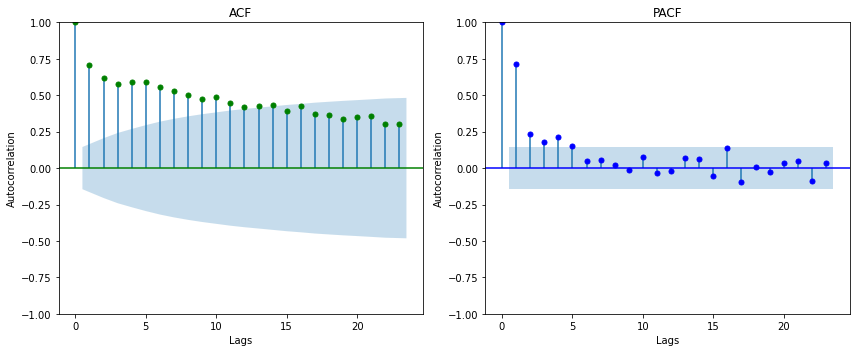

In [27]:
# Grid Vis
fig = make_subplots(rows=2, cols=2, )
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


for ax in axs:
    ax.set_xlabel('Lags', color='black')
    ax.set_ylabel('Autocorrelation', color='black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.title.set_color('black')

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_color('black')


# ACF/ PACF Drawing
plot_acf(group_clean_data['Cases_Number'], ax=axs[0], title='ACF', color='green')
plot_pacf(group_clean_data['Cases_Number'], ax=axs[1], title='PACF', color='blue')

plt.tight_layout()
plt.show()


#### Intensity Frequency Analysis
After thoroughly analyzing the regular pattern period, we can utilize the Exponential Moving Average (EMA) to assess and confirm the seasonal intensity of data that does not exhibit a trend. This method allows us to pinpoint specific periods when fraud cases are on the rise and when they are decreasing.

We prefer the Exponential Moving Average (EMA) over the Simple Moving Average (MA) because it minimizes the influence of historical data on future predictions, as illustrated in the Autocorrelation Function (ACF) plot. These factors are essential to our analysis.


In [28]:
# Decided by previous ACF
WINDOW_SIZE = 12

model = ExponentialSmoothing(group_clean_data.no_trend, seasonal='add', seasonal_periods=WINDOW_SIZE)
ema_results = model.fit(optimized=True)

# find peaks
peaks, properties = find_peaks(ema_results.fittedvalues.values)
# print("Peaks Value:", ema_results.fittedvalues.iloc[peaks])

no_trend_ema = [
    go.Scatter(x=ema_results.fittedvalues.index, y=ema_results.fittedvalues, name='Cases_Number'),
    go.Scatter(x=ema_results.fittedvalues.iloc[peaks].index,
                         y=ema_results.fittedvalues.iloc[peaks].values,
                         mode='markers',
                         marker=dict(symbol="x", size=10, color='red'),
                         name='peaks')
]
time_series_vis(f'Trend Removed Cases Data EMA({WINDOW_SIZE})', no_trend_ema)

#### Fourier Transform
To begin with, we aim to comprehend the frequency of patterns. While we are aware of the routine period, the intensity frequency remains unclear. To uncover this information, we will utilize the Fourier Transform.


In [29]:
from scipy.fft import fft, fftfreq, ifft

y = ema_results.fittedvalues.values
n = len(y)
T = 1

yf = fft(y)
xf = fftfreq(n, T)[:n//2]


amplitude = 2.0/n * np.abs(yf[0:n//2])

peaks, _ = find_peaks(amplitude, height=20)
peak_values = amplitude[peaks]

frequencies = xf[peaks]
inverse_frequencies = 1 / frequencies

for freq, peak, inv_freq in zip(xf[peaks], peak_values, inverse_frequencies):
    print(f"Frequency: {freq:.2f} Hz, Peak: {peak:.2f}, inverse_frequencies: {inv_freq:.2f} weeks")


fig = go.Figure()
fig.add_trace(go.Scatter(x=xf, y=amplitude, mode='lines', name='Magnitude'))

fig.update_layout(
        title='Fourier Transform Spectrum',
        xaxis_title='Frequency (Hz)',
      yaxis_title='Magnitude',
      template='plotly_white',
        height=500,
        font=dict(color='Black'),
        xaxis=dict(
            showgrid=True,
            gridwidth=0.001,
            gridcolor='rgba(255, 255, 255, 0.1)',
            griddash='dash',
            zeroline=False
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=0.001,
            gridcolor='rgba(255, 255, 255, 0.1)',
            griddash='dash',
            zeroline=False
        )
    )
fig.show()

Frequency: 0.08 Hz, Peak: 47.03, inverse_frequencies: 12.20 weeks
Frequency: 0.16 Hz, Peak: 33.75, inverse_frequencies: 6.10 weeks
Frequency: 0.25 Hz, Peak: 52.98, inverse_frequencies: 3.98 weeks
Frequency: 0.33 Hz, Peak: 31.37, inverse_frequencies: 3.00 weeks
Frequency: 0.42 Hz, Peak: 37.43, inverse_frequencies: 2.41 weeks


#### Crrelation Analysis (Week of Month & Month)

We performed a ***Chi-square test*** to assess whether the frequency of fraud cases varied significantly across different weeks of the month and across various months. The objective was to identify any discernible patterns in the timing of fraud incidents, which could help reveal if particular weeks within a month are more susceptible to fraud, depending on the month.

In [30]:
clean_data['Month'] = clean_data.index.month
def get_week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    if (dom + first_day.weekday() - 1) // 7 + 1 < 6:

      return (dom + first_day.weekday() - 1) // 7 + 1

clean_data['WeekOfMonth'] = clean_data.index.map(get_week_of_month)

Chi-squared: 10166.38
p-value: 0.0
Degrees of Freedom: 44
Results are significant: There is a significant correlation between the occurrence of fraud cases and the month and week of the month.


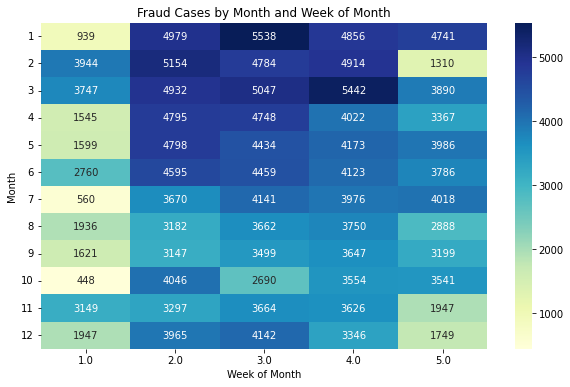

In [31]:
contingency_table = pd.crosstab(clean_data['Month'], clean_data['WeekOfMonth'])

chi2, p, dof, ex = chi2_contingency(contingency_table.values)

print(f"Chi-squared: {chi2:.2f}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p < alpha:
    print("Results are significant: There is a significant correlation between the occurrence of fraud cases and the month and week of the month.")
else:
    print("Results are not significant: We cannot reject the hypothesis that the occurrence of fraud cases is not related to the month and week of the month.")
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Fraud Cases by Month and Week of Month')
plt.xlabel('Week of Month')
plt.ylabel('Month')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


The chi-square test conducted on the relationship between "month" and "week of the month" indicates a significant correlation, with a p-value less than 0.05. This suggests that certain months are associated with a higher frequency of fraud cases occurring during specific weeks.



## Conclusion

Based on the analyses conducted, the following conclusions are drawn:

There is a notable downward trend in the number of fraud cases over the analyzed period.

Periodic patterns of 12 weeks and 4 weeks are observed, with future predictions suggesting continued peaks during specific periods, particularly within the 4-week, 6-week, and 12-week cycles, where risks are expected to increase significantly.

The Chi-square test results affirm a substantial relationship between the month and week of the month concerning fraud cases, offering valuable insights for risk forecasting and resource allocation.

These insights provide substantial data support for organizations, aiding them in making well-informed decisions regarding resource allocation and risk management.


---

# GENDER ANALYSIS

## Analysis for Gender

In [ ]:
clean_data = data_cleaning_4_raw(data)
df = clean_data

First, lets find out the unique values in Gender Column.

In [36]:
df['Gender'].unique()

array(['Not Available', 'Male', 'Female', 'Unknown', 'Prefer not to say',
       'Other'], dtype=object)

For our analysis, we will consider three categories: `Male`, `Female` and `Unspecified`

In [37]:
df_gender = df
df_gender['Gender'] = df_gender['Gender'].replace({'Not Available' : 'Unspecified',
                                                   'Unknown' : 'Unspecified',
                                                   'Prefer not to say':
                                                   'Unspecified', 'Other' : 'Unspecified'})

Let's find out the total number of attempts made by fraudster foe each genders per year from 2021 to 1st half of 2024.
To do the same, we need to add a new column for year

In [38]:
df_gender['Year'] = df_gender['Date_Received'].dt.year

Now, let's find out the total attempts for each genders per year.

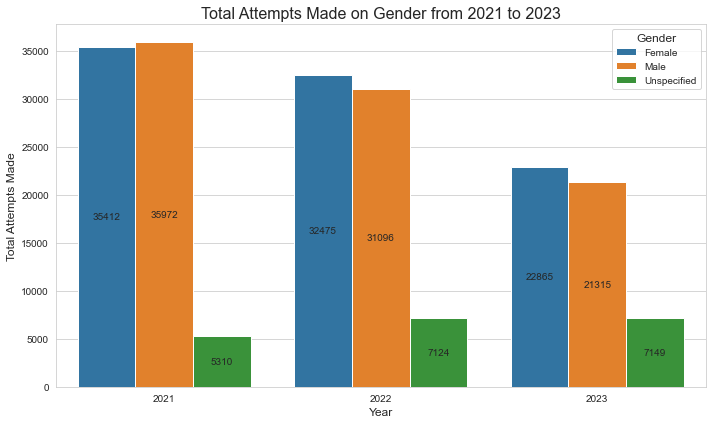

In [42]:
total_complaints_for_gender = df_gender.groupby(['Year','Gender']).agg(Total_attempts_made=('Gender', 'count')).reset_index()
total_complaints_filtered = total_complaints_for_gender[total_complaints_for_gender['Year'] != 2024]

sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Year', y='Total_attempts_made', hue='Gender', data=total_complaints_filtered)

plt.title('Total Attempts Made on Gender from 2021 to 2023', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Attempts Made', fontsize=12)
plt.legend(title='Gender', title_fontsize='12', fontsize='10')

plt.xticks(rotation=0)


for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.show()

At first look, we can observe that the overall fraud attempts made on males and females declined over time, however the same for unspecified gender climbed at a very low rate.

In addition to that, the attempts made on males in the year 2021 were more than those of females. In stark contrast, the attempts on females were more in other years.



So far we have only seen the total numbers of attempts made on each genders

Now, let's see the number of actual victims

In [43]:
actual_victims_by_gender = df_gender.groupby(['Year','Gender']).agg(Total_attempts_made=('Gender', 'count'), Total_Victims=('Number_of_Victims','sum')).reset_index()
actual_victims_by_gender

,Year,Gender,Total_attempts_made,Total_Victims
0,2021,Female,35412,23871
1,2021,Male,35972,25415
2,2021,Unspecified,5310,2683
3,2022,Female,32475,21699
4,2022,Male,31096,21350
5,2022,Unspecified,7124,3513
6,2023,Female,22865,15511
7,2023,Male,21315,15057
8,2023,Unspecified,7149,4181
9,2024,Female,7751,5785


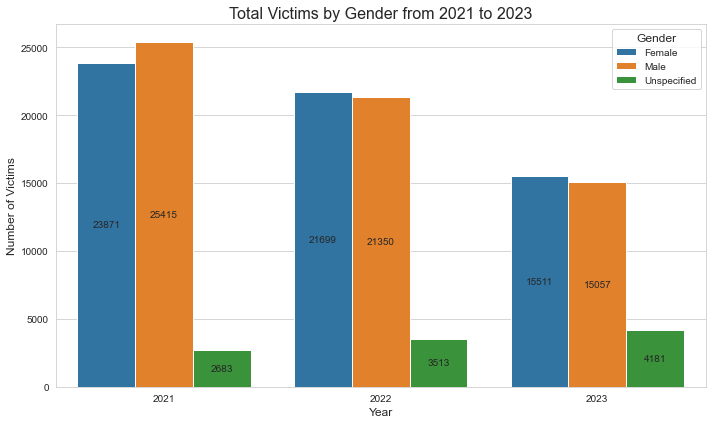

In [44]:
actual_victims_filtered = actual_victims_by_gender[actual_victims_by_gender['Year'] != 2024]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Year', y='Total_Victims', hue='Gender', data=actual_victims_filtered)

plt.title('Total Victims by Gender from 2021 to 2023', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Victims', fontsize=12)
plt.legend(title='Gender', title_fontsize='12', fontsize='10')
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.show()


It is clearly seen that the highest number of males were victims in 2021; this number was 25415 and was the all-time highest. After this, the number went down.

In the years 2022 and 2023, the number of female victims was higher than those made on males.

In the first half of 2024, the number of male and female victims was nearly the same.

Now, let's compare the Total Attempts made and Total Victims for each genders

In [45]:
actual_victims_filtered = actual_victims_by_gender[actual_victims_by_gender['Year'] != 2024]

df_melted = actual_victims_filtered.melt(id_vars=['Year', 'Gender'], var_name='Metric', value_name='Count')

fig3 = px.line(df_melted, x='Year', y='Count', color='Gender', facet_col='Metric', markers=True,
               title='Comparison of Total Attempts and Total Victims by Gender from 2021 to 2023')
fig3.show()

From 2021 to 2023, there was a downward trend in the overall number of victims and attempts made by both males and females.

Females consistently had slightly more attempts than males in the "Total Attempts Made" metric, but this gap narrows by 2023.

Male and female victims show comparable trends overall, with the difference between them narrowing with time.

The Unspecified category remains constant and significantly lower in both attempts and victims.

This also indicates a general reduction in both the number of attempts and victims across the years, potentially due to improved prevention or reporting measures.

Based on the data we have, we can calculate the ratio of Total Victims to Total attempts made.

In [48]:
actual_victims_by_gender['Victimization_Rate'] = actual_victims_by_gender['Total_Victims'] / actual_victims_by_gender['Total_attempts_made']
actual_victims_by_gender

,Year,Gender,Total_attempts_made,Total_Victims,Victimization_Rate
0,2021,Female,35412,23871,0.674094
1,2021,Male,35972,25415,0.706522
2,2021,Unspecified,5310,2683,0.505273
3,2022,Female,32475,21699,0.668176
4,2022,Male,31096,21350,0.686583
5,2022,Unspecified,7124,3513,0.493122
6,2023,Female,22865,15511,0.678373
7,2023,Male,21315,15057,0.706404
8,2023,Unspecified,7149,4181,0.584837
9,2024,Female,7751,5785,0.746355


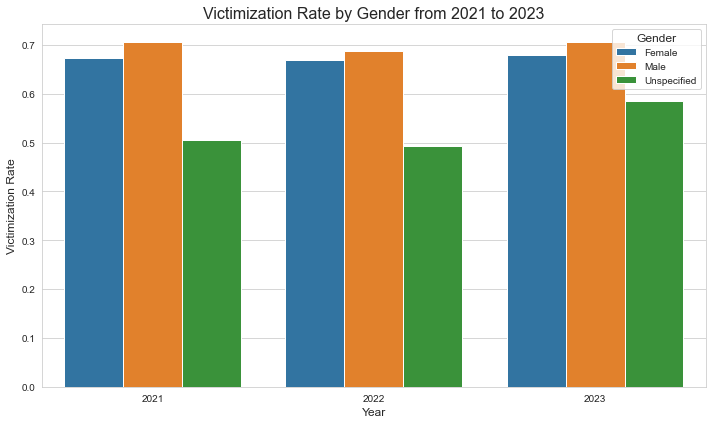

In [51]:
actual_victims_filtered = actual_victims_by_gender[actual_victims_by_gender['Year'] != 2024]

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Year', y='Victimization_Rate', hue='Gender', data=actual_victims_filtered)

plt.title('Victimization Rate by Gender from 2021 to 2023', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Victimization Rate', fontsize=12)
plt.legend(title='Gender', title_fontsize='12', fontsize='10')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

The relative victimization rates of men and women do not significantly differ over the course of the three years, with the exception that by 2022 and 2023, the difference between the two groups appears to be closing.

Now, let's find the tremd of different fraud categories by Gender.

In [52]:
fraud_categories_by_gender = df_gender.groupby(['Gender', 'Fraud_and_Cybercrime_Thematic_Categories']).size().reset_index(name='Count')
fraud_categories_by_gender

,Gender,Fraud_and_Cybercrime_Thematic_Categories,Count
0,Female,Bank Investigator,4941
1,Female,Charity / Donation,108
2,Female,Collection Agency,428
3,Female,Counterfeit Merchandise,1135
4,Female,Credit Card,14
...,...,...,...
109,Unspecified,Timeshare,14
110,Unspecified,Unauthorized Charge,7
111,Unspecified,Unknown,1051
112,Unspecified,Vacation,9


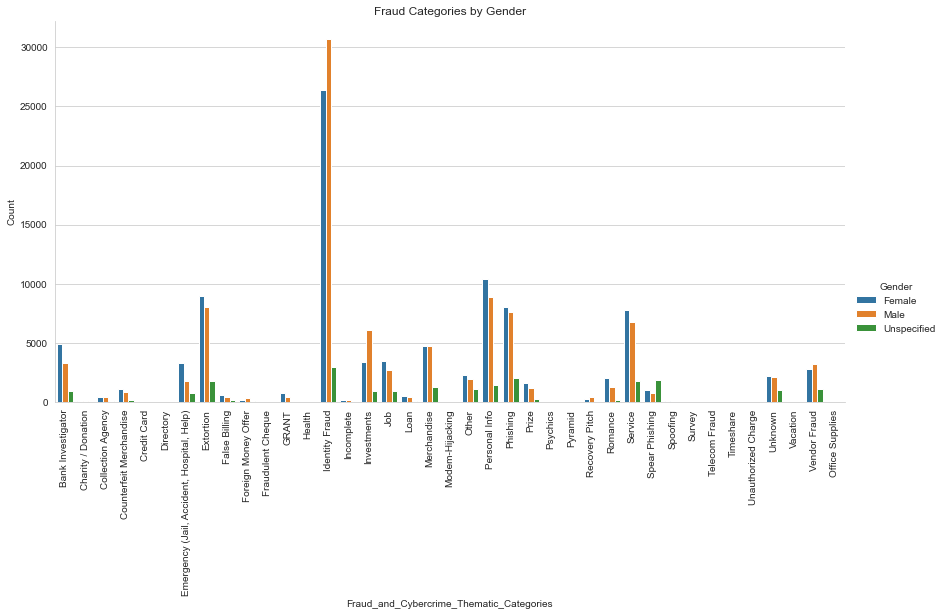

In [53]:
fig = sns.catplot(x='Fraud_and_Cybercrime_Thematic_Categories', y='Count', hue='Gender', data=fraud_categories_by_gender, kind='bar', height=6, aspect=2)
plt.xticks(rotation=90)
plt.title('Fraud Categories by Gender')
plt.show()

The most common form of fraud across all gender groups is identity fraud, with over 30,000 cases affecting men and slightly over 25,000 cases affecting women. Even if it is much smaller, the undefined gender group is still noticeable.

In most areas of fraud, including identity theft, tech support, online shopping, and auction fraud, the proportion of male victims is higher.

In most categories, females have slightly fewer cases than males, although their distribution is similar.

There are comparatively fewer examples of the unspecified gender category in all fraud kinds, but it is present in some notable categories, such as online shopping/auctions, identity fraud, and tech support.


## Conclusion

According to the data analysis, fraud and victimization patterns are similar for men and women, with men being somewhat more affected in the majority of categories. For men as well as women, identity fraud is the most common kind of fraud, with tech support scams coming in second. The number of victims and attempts for both genders decreased between 2021 and 2023, however the victimization rate for the undefined gender group increased over time and remained continuously low. In general, men dominate the majority of fraud categories; yet, the disparity in impact between genders is negligible, underscoring the pervasiveness of deception in society.

---

# AGE ANALYSIS

## Analysis for Age Group

In [54]:
clean_data = data_cleaning_4_raw(data)
df = clean_data

/var/folders/21/_661td0j1cddth8c88wkc_880000gn/T/ipykernel_99624/348637590.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



First, lets find out the unique values in Age Column.

In [ ]:
age_unique = df['Victim_Age_Range'].unique()
age_unique

array(["'Not Available / non disponible", "'40 - 49", "'30 - 39",
       "'60 - 69", "'70 - 79", "'10 - 19", "'20 - 29", "'50 - 59",
       "'80 - 89", "'1 - 9", "'Deceased / Décédé", "'90 - 99", "'100 +",
       "'Business / Entreprise"], dtype=object)

In [ ]:
df_age = df.copy()
df_age.loc[:, 'Victim_Age_Range'] = df_age['Victim_Age_Range'].replace({
    "'1 - 9" : "Under 19",
    "'10 - 19" : "Under 19",
    "'20 - 29": "20 - 39",
    "'30 - 39": "20 - 39",
    "'40 - 49": "40 - 59",
    "'50 - 59": "40 - 59",
    "'60 - 69": "60 - 79",
    "'70 - 79": "60 - 79",
    "'80 - 89": "Above 80",
    "'90 - 99": "Above 80",
    "'100 +": "Above 80",
    "'Not Available / non disponible" : 'Not Specified',
    "'Deceased / Décédé" : 'Deceased',
    "'Business / Entreprise": "Not Specified"
})

Find out which age group was targeted the most

In [ ]:
age_order = ['Under 19', '20 - 39', '40 - 59', '60 - 79', 'Above 80', 'Deceased', 'Not Specified']
df_age['Victim_Age_Range'] = pd.Categorical(df_age['Victim_Age_Range'], categories=age_order, ordered=True)

total_complaints_for_age = df_age.groupby(['Victim_Age_Range'], observed=False).agg(
    Total_attempts_made=('Victim_Age_Range', 'count')
).reset_index()

total_complaints_for_age = total_complaints_for_age.sort_values('Victim_Age_Range')
total_complaints_for_age

,Victim_Age_Range,Total_attempts_made
0,Under 19,8962
1,20 - 39,65683
2,40 - 59,60769
3,60 - 79,51814
4,Above 80,7051
5,Deceased,140
6,Not Specified,21926


### Visualizing the above findings

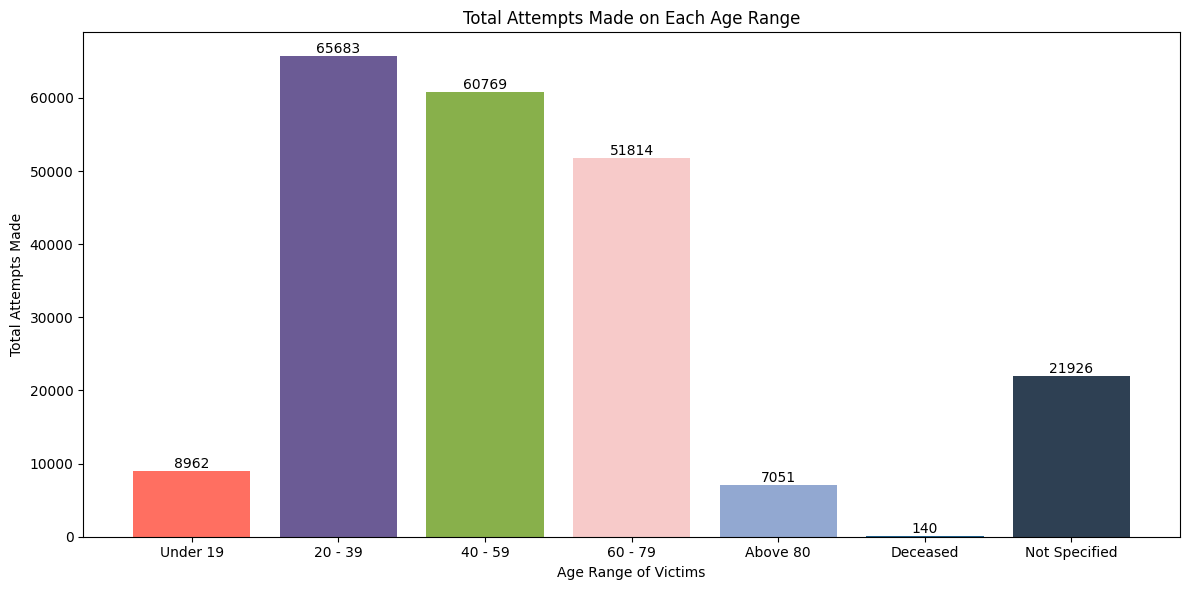

In [ ]:
colors = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1', '#1F618D', '#2E4053']

plt.figure(figsize=(12, 6))
bars = plt.bar(total_complaints_for_age["Victim_Age_Range"], total_complaints_for_age["Total_attempts_made"], color=colors)
plt.title("Total Attempts Made on Each Age Range", fontsize=12)
plt.xlabel("Age Range of Victims", fontsize=10)
plt.ylabel("Total Attempts Made", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xticks(rotation=0, fontsize=10)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The bar graph provides a clear and informative depict of how various age groups are impacted by the total number of attempts.

The "20-39" age group had the most attempts with a total of 65,683, followed by "40-59" with 60,769.

There were also a lot of attempts at 51,814 for the age group "60 - 79".

Interestingly, the "Above 80" age group, with 7,051 attempts, shows a higher number of attempts than the "Deceased" group (140), but fewer attempts than the "Under 19" group (8,962) and the "Not Specified" category (21,908).

The "Not Specified" group had a comparatively high number of attempts (21,908), suggesting that victims may not have provided clear data.

In conclusion, this chart provides a clear visual depiction of the data, showing how attempts varied across age ranges, with the majority of attempts concentrated in the younger to middle-aged categories.


### Now let's check which age range was targeted by which method

In [ ]:
df_age_updated = df_age.groupby(['Victim_Age_Range', 'Solicitation Method'], observed=False)['Number_of_Victims'].sum().reset_index()
df_age_updated

,Victim_Age_Range,Solicitation Method,Number_of_Victims
0,Under 19,Direct call,485
1,Under 19,Door to door/in person,91
2,Under 19,Email,208
3,Under 19,Fax,1
4,Under 19,Internet,393
...,...,...,...
93,Not Specified,Print,0
94,Not Specified,Radio,0
95,Not Specified,Television,0
96,Not Specified,Text message,332


### Under 19

In [ ]:
age_u19 = df_age_updated[df_age_updated['Victim_Age_Range']=='Under 19'].sort_values('Number_of_Victims', ascending=False)
age_u19

,Victim_Age_Range,Solicitation Method,Number_of_Victims
8,Under 19,Other/unknown,5708
5,Under 19,Internet-social network,777
0,Under 19,Direct call,485
4,Under 19,Internet,393
12,Under 19,Text message,343
2,Under 19,Email,208
7,Under 19,Not Available,156
1,Under 19,Door to door/in person,91
6,Under 19,Mail,11
13,Under 19,Video Call,3


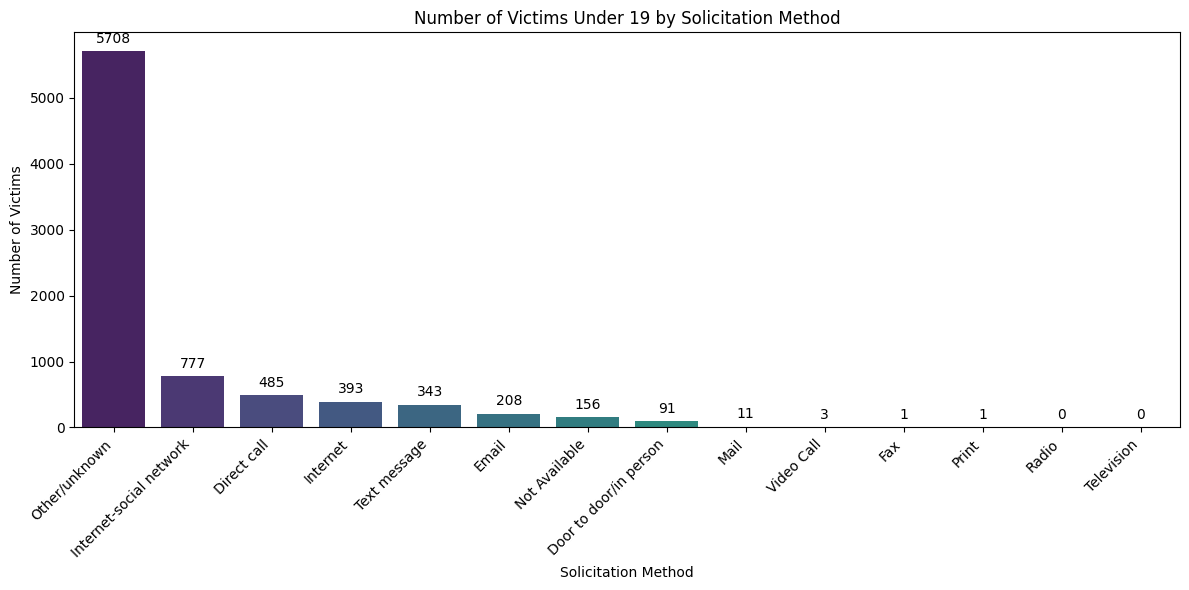

In [ ]:
age_u19 = df_age_updated[df_age_updated['Victim_Age_Range'] == 'Under 19'].sort_values('Number_of_Victims', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=age_u19, x='Solicitation Method', y='Number_of_Victims', hue='Solicitation Method', palette='viridis')
plt.title('Number of Victims Under 19 by Solicitation Method',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

The bar chart shows the number of victims under 19 by solicitation method, revealing that the vast majority of cases (5708) fall under the "Other/Unknown" category, highlighting a significant lack of specificity in reporting.

The "Internet/Social Network" method comes next, with 777 victims, demonstrating the significance of online mediums in targeting young people.

Other methods, such as direct calls (485 victims) and text messages (343 victims), are less common but equally significant. Traditional methods such as mail, video calls, and fax have low usage, with victim counts in the single digits or close to zero.

In conclusion, the chart illustrates the importance of addressing online safety for youth, particularly in the context of social networks.

### <b>For 20-39 age group</b>

In [ ]:
age_20_39 = df_age_updated[df_age_updated['Victim_Age_Range']=='20 - 39'].sort_values('Number_of_Victims', ascending=False)
age_20_39

,Victim_Age_Range,Solicitation Method,Number_of_Victims
22,20 - 39,Other/unknown,25887
19,20 - 39,Internet-social network,7169
14,20 - 39,Direct call,5529
18,20 - 39,Internet,5011
16,20 - 39,Email,2714
26,20 - 39,Text message,2113
21,20 - 39,Not Available,1336
15,20 - 39,Door to door/in person,795
20,20 - 39,Mail,163
27,20 - 39,Video Call,12


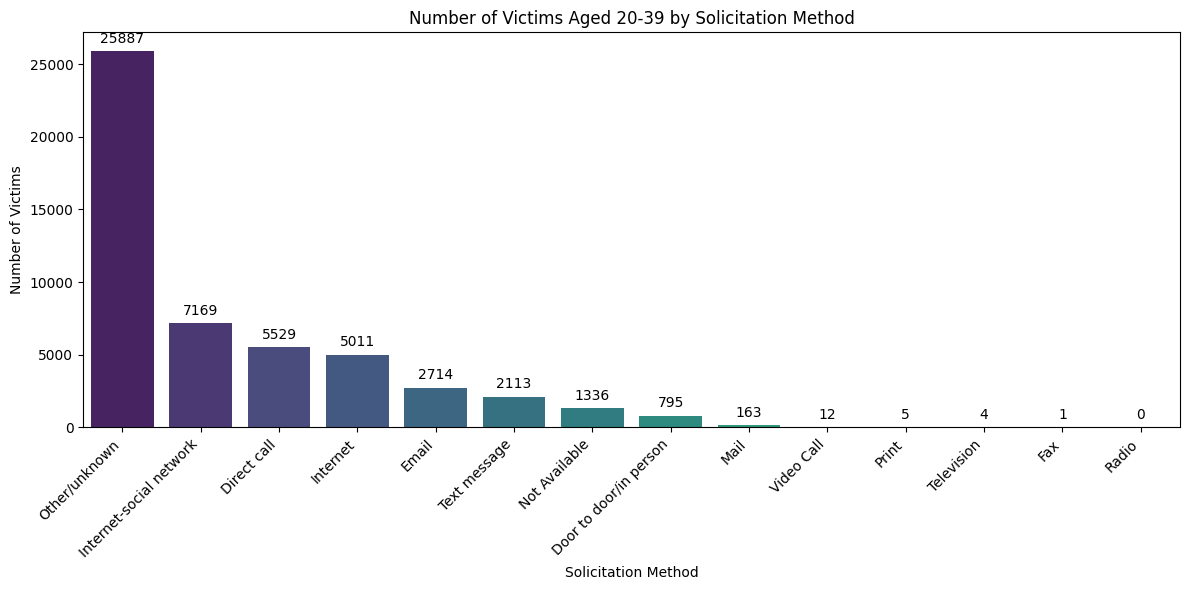

In [ ]:
age_20_39 = df_age_updated[df_age_updated['Victim_Age_Range'] == '20 - 39'].sort_values('Number_of_Victims', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=age_20_39, x='Solicitation Method', y='Number_of_Victims', hue='Solicitation Method', palette='viridis')
plt.title('Number of Victims Aged 20-39 by Solicitation Method',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

This bar graph illustrates the “Other/Unknown” category is the most significant, with over 25000 cases, which is higher than all other age groups.

The most often utilized specific method, "Internet/Social Network," has over 7000 victims, indicating the important role that online platforms play in attracting victims in this age range.

While other methods like mail, video calls, and print are rarely used, traditional methods like direct calls and emails are still very important.

In conclusion, the chart underscores the critical need to focus on internet-based safety measures for the 20-39 age group and calls.

### <b>For 40-59 age group</b>

In [ ]:
age_40_59 = df_age_updated[df_age_updated['Victim_Age_Range']=='40 - 59'].sort_values('Number_of_Victims', ascending=False)
age_40_59

,Victim_Age_Range,Solicitation Method,Number_of_Victims
36,40 - 59,Other/unknown,22251
33,40 - 59,Internet-social network,5088
32,40 - 59,Internet,4993
28,40 - 59,Direct call,4496
30,40 - 59,Email,1998
40,40 - 59,Text message,1496
35,40 - 59,Not Available,1099
29,40 - 59,Door to door/in person,698
34,40 - 59,Mail,184
39,40 - 59,Television,13


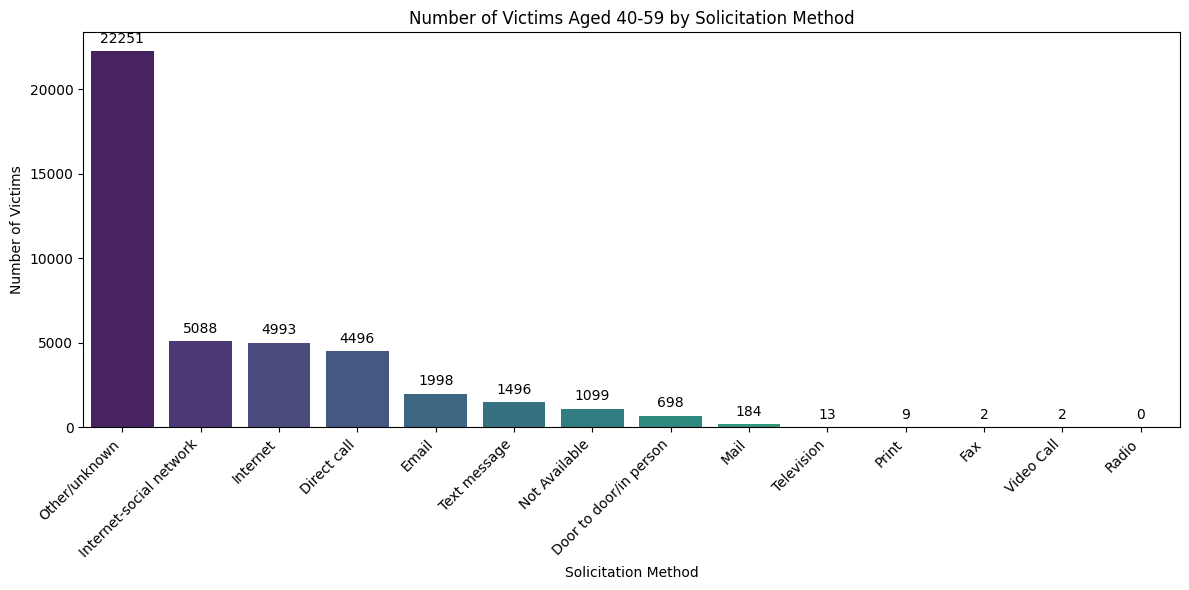

In [ ]:
age_40_59 = df_age_updated[df_age_updated['Victim_Age_Range'] == '40 - 59'].sort_values('Number_of_Victims', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=age_40_59, x='Solicitation Method', y='Number_of_Victims', hue='Solicitation Method', palette='viridis')
plt.title('Number of Victims Aged 40-59 by Solicitation Method',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.tight_layout()
plt.show()

The illustration suggests that the vast majority of victims more than 22,000 fall into the "Other/Unknown" category, which is the largest category.

Internet/Social Network" continues to be the most popular targeted method of solicitation for people between the ages of 40 and 59, with over 5000 victims.

While less common, traditional approaches like direct call, email, and text messaging are still important. Fewer people are impacted by less popular techniques like mail, television, and print.

Finally, the chart shows that internet-based methods continue to dominate, but there are a significant number of cases that lack specific classification, which could cover up important insights into the methods of solicitation for this age group.

### <b>For 60 -79 age group</b>

In [ ]:
age_60_79 = df_age_updated[df_age_updated['Victim_Age_Range']=='60 - 79'].sort_values('Number_of_Victims', ascending=False)
age_60_79

,Victim_Age_Range,Solicitation Method,Number_of_Victims
50,60 - 79,Other/unknown,11460
42,60 - 79,Direct call,6718
46,60 - 79,Internet,4719
47,60 - 79,Internet-social network,3038
44,60 - 79,Email,1951
54,60 - 79,Text message,989
49,60 - 79,Not Available,724
43,60 - 79,Door to door/in person,474
48,60 - 79,Mail,153
53,60 - 79,Television,20


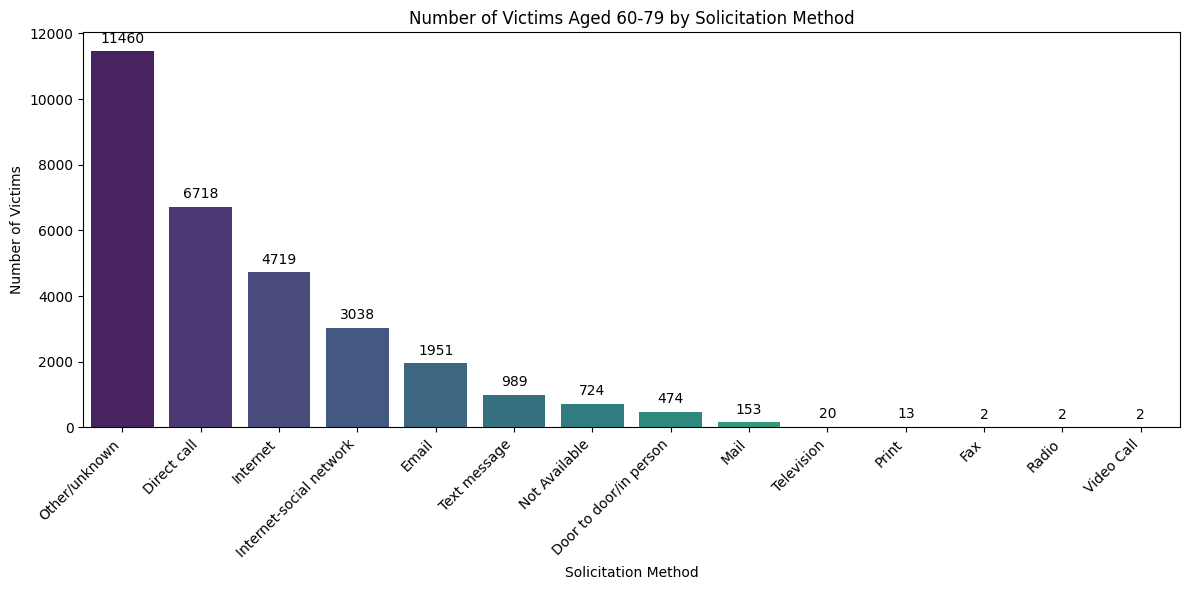

In [ ]:
age_60_79 = df_age_updated[df_age_updated['Victim_Age_Range'] == '60 - 79'].sort_values('Number_of_Victims', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=age_60_79, x='Solicitation Method', y='Number_of_Victims', hue='Solicitation Method', palette='viridis')
plt.title('Number of Victims Aged 60-79 by Solicitation Method',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.tight_layout()
plt.show()

The bar chart depicts the number of victims aged 60 to 79, organized by the mode of solicitation. The most frequent category is "Other/Unknown," which accounts for 11,460 victims and is by far the most commonly reported technique.

"Direct Call" comes in second with 6,718 victims, followed by "Internet" with 4,719 victims. Social media-related scams via "Internet-Social Network" have a significant number of victims, with 3,038.

"Email" (1,951 victims), "Text message" (989 victims), and "Not Available" (724 victims) are among the less commonly utilized solicitation tactics. Methods such as "Door to door/in person" (474), "Mail" (153), "Television" (20), "Print" (13), "Fax," "Radio," and "Video Call" (2 victims each) are on the lowest end of the spectrum, showing negligible use in targeting this age group.

According to the bar plot, older persons are most commonly exploited by ambiguous or unidentifiable solicitation methods, phone calls, and internet platforms. Social networks and email are other popular channels, with traditional media like television, print, and fax playing a modest part.

### <b>For Above 80 age group</b>

In [ ]:
age_a80 = df_age_updated[df_age_updated['Victim_Age_Range']=='Above 80'].sort_values('Number_of_Victims', ascending=False)
age_a80

,Victim_Age_Range,Solicitation Method,Number_of_Victims
56,Above 80,Direct call,1933
64,Above 80,Other/unknown,766
60,Above 80,Internet,447
58,Above 80,Email,256
61,Above 80,Internet-social network,163
63,Above 80,Not Available,121
57,Above 80,Door to door/in person,67
68,Above 80,Text message,66
62,Above 80,Mail,36
65,Above 80,Print,5


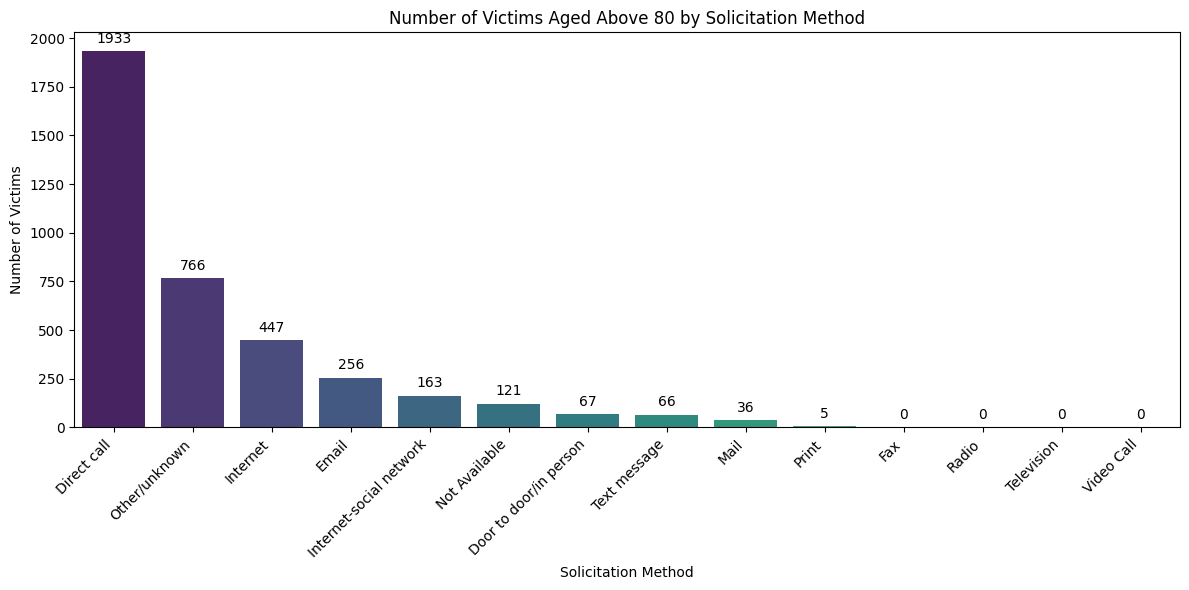

In [ ]:
age_a80 = df_age_updated[df_age_updated['Victim_Age_Range'] == 'Above 80'].sort_values('Number_of_Victims', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=age_a80, x='Solicitation Method', y='Number_of_Victims', hue='Solicitation Method', palette='viridis')
plt.title('Number of Victims Aged Above 80 by Solicitation Method',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.tight_layout()
plt.show()

Based on the technique used to solicit them, the bar chart displays the number of victims who are older than 80. "Direct Call" is the most popular approach, impacting 1,933 victims. With 766 victims, "Other/Unknown" is the next highest category. Internet (447 victims) and email (256 victims) are next in line. 163 victims were also impacted by social networks.

Less frequently used techniques included "Not Available" (121 victims), "Door to door/in person" (67 victims), and "Text message" (66 victims). Conventional approaches such as "Mail" (36 casualties) and "Print" (5 casualties) have little effect, whereas "Fax," "Radio," "Television," and "Video Call" have no casualties.

Scammers most frequently target victims over the age of 80 by phone, then online.Fewer people in this age group are also affected by traditional methods.

### <b> Deceased</b> :

The term "deceased" describes people who have passed away and whose identities or private information could be used by scammers.

In [ ]:
deceased = df_age_updated[df_age_updated['Victim_Age_Range']=='Deceased'].sort_values('Number_of_Victims', ascending=False)
deceased

,Victim_Age_Range,Solicitation Method,Number_of_Victims
78,Deceased,Other/unknown,93
75,Deceased,Internet-social network,6
74,Deceased,Internet,5
70,Deceased,Direct call,4
76,Deceased,Mail,4
71,Deceased,Door to door/in person,3
72,Deceased,Email,1
77,Deceased,Not Available,1
82,Deceased,Text message,1
73,Deceased,Fax,0


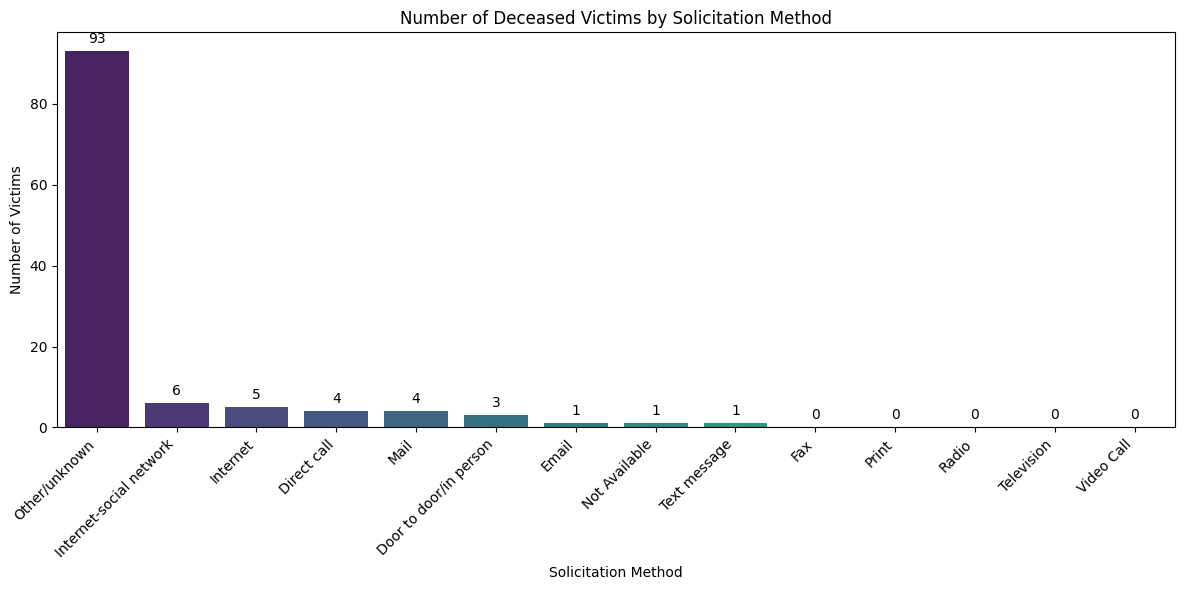

In [ ]:
deceased = df_age_updated[df_age_updated['Victim_Age_Range'] == 'Deceased'].sort_values('Number_of_Victims', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(deceased, x='Solicitation Method', y='Number_of_Victims', hue='Solicitation Method', palette='viridis')
plt.title('Number of Deceased Victims by Solicitation Method',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.tight_layout()
plt.show()

The number of victims who have passed away is shown in a bar chart arranged by mode of solicitation.Out of all the methods, the "Other/Unknown" group had the most victims (93). Following "Internet" with 5 victims, "Internet-Social Network" claimed 6 victims. Four victims were linked to "Direct Call" and "Mail," and three to "Door to Door/In Person." "Fax," "Print," "Radio," "Television," and "Video Call" had no documented casualties. "Email," "Not Available," and "Text Message" each had one victim.

The majority of deceased victims were affected by unknown or unidentified solicitation tactics. Social networks and internet platforms are also significant sources of victimization, with direct calls and mail having a lesser influence.

### <b> Not Specified</b>

In [ ]:
age_Ns = df_age_updated[df_age_updated['Victim_Age_Range']=='Not Specified'].sort_values('Number_of_Victims', ascending=False)
age_Ns

,Victim_Age_Range,Solicitation Method,Number_of_Victims
92,Not Specified,Other/unknown,3278
86,Not Specified,Email,1838
88,Not Specified,Internet,1795
84,Not Specified,Direct call,1604
89,Not Specified,Internet-social network,1423
91,Not Specified,Not Available,496
96,Not Specified,Text message,332
85,Not Specified,Door to door/in person,165
90,Not Specified,Mail,52
87,Not Specified,Fax,2


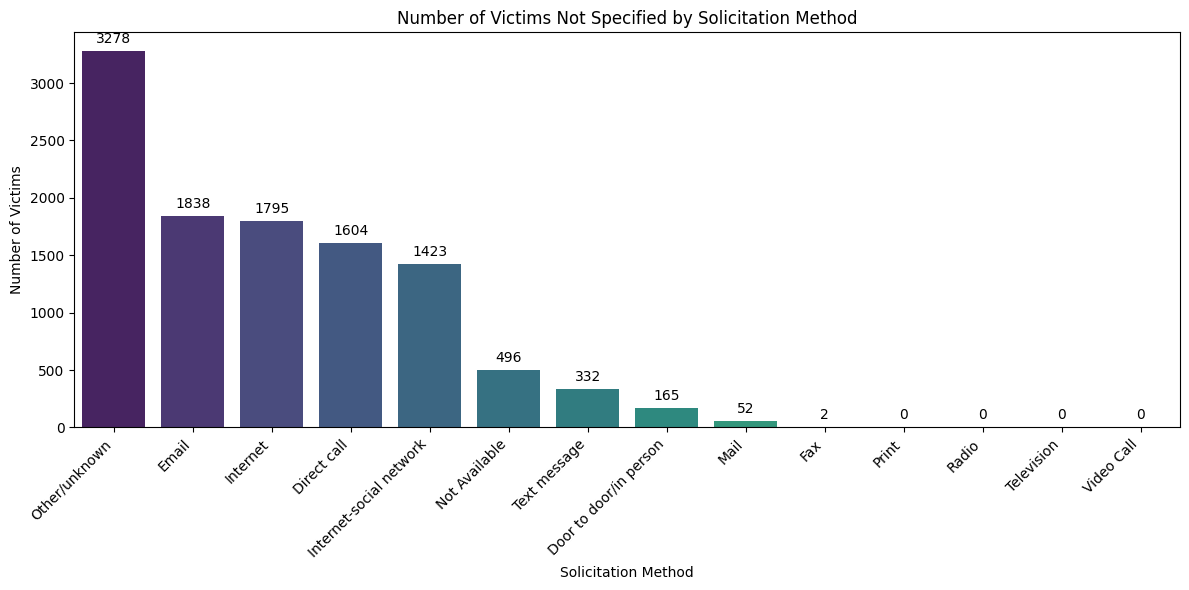

In [ ]:
age_Ns = df_age_updated[df_age_updated['Victim_Age_Range'] == 'Not Specified'].sort_values('Number_of_Victims', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=age_Ns, x='Solicitation Method', y='Number_of_Victims', hue='Solicitation Method', palette='viridis')
plt.title('Number of Victims Not Specified by Solicitation Method',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Number of Victims')
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.tight_layout()
plt.show()

The bar chart depicts the number of victims based on the various solicitation approaches. The largest group, with 3,278 victims, falls into the "Other/Unknown" category, indicating that the manner of solicitation was not disclosed. Email (1,838 victims) and the internet (1,795 victims) are the second most popular tactics, followed by direct calls (1,604) and internet-social networks (1,423).

A smaller number of victims were reached via text message (332), door-to-door (165), and mail (52). Only two victims were contacted via fax, with no victims reported via print, radio, television, or video communications.

Overall, The most prevalent ways victims are targeted are via email and the internet, whereas older techniques such as mail and fax are far less common. The big "Other/Unknown" category shows that many instances lack clear information about the method used.

### <b>Total attempts by Fraud Method</b>

<ipython-input-27-7c9d3c84c50a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_counts, x='Solicitation Method', y='Count', palette='viridis')


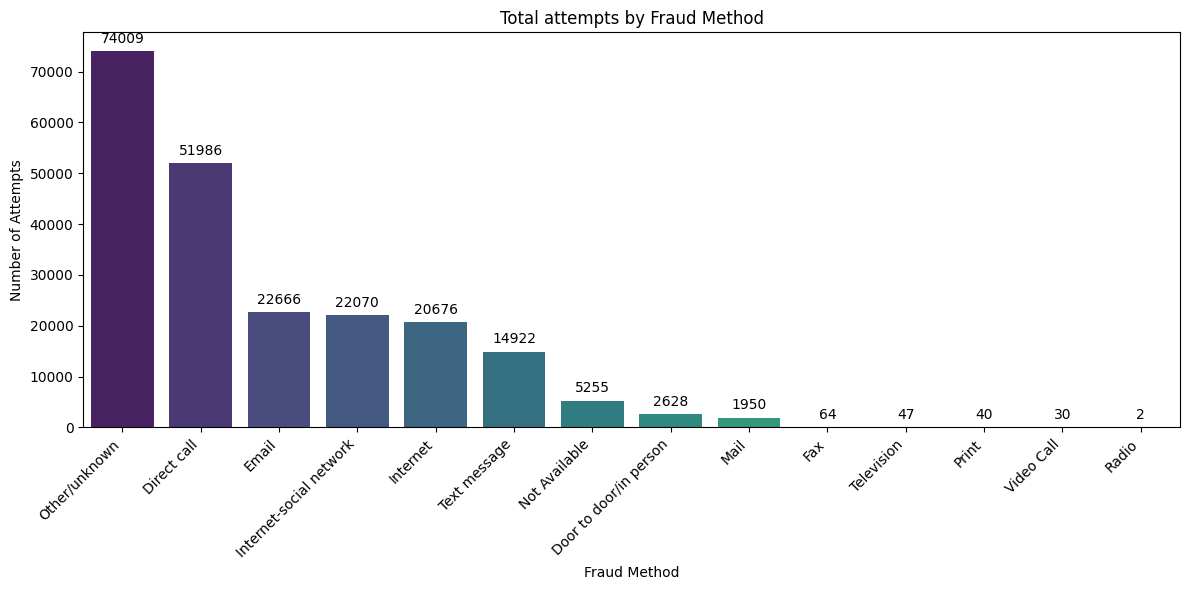

In [ ]:
df_counts = df['Solicitation Method'].value_counts().reset_index()
df_counts.columns = ['Solicitation Method', 'Count']

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_counts, x='Solicitation Method', y='Count', palette='viridis')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.title('Total attempts by Fraud Method',fontsize=12)
plt.xlabel('Fraud Method')
plt.ylabel('Number of Attempts')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

The bar chart illustrates the total number of fraud attempts by various methods. The “Other/Unknown” category stands out with 74,009 attempts, suggesting that many fraud cases are either unclassified or unspecified. Direct calls follow closely with 51,986 attempts, showing that fraudsters heavily rely on direct communication to target individuals.

Digital platforms also play a significant role in fraud, with email (22,666 attempts), internet-social networks (22,070 attempts), and general internet usage (20,676 attempts) being major channels. Text messaging accounts for 14,922 fraud attempts, while cases with unclear methods (“Not Available”) total 5,255 attempts.

In contrast, less common methods include door-to-door/in-person fraud (2,628 attempts), mail (1,950 attempts), and fax (64 attempts). Fraud through television, print, video calls, and radio is minimal, with very few reported cases, ranging from 47 to just 2 attempts.

Conclusion,The data highlights that fraud attempts are predominantly conducted through digital platforms and direct calls, reflecting the widespread use of these channels by fraudsters.Traditional methods like in-person solicitations and mail are far less common, while radio, print, and video call fraud are nearly negligible.


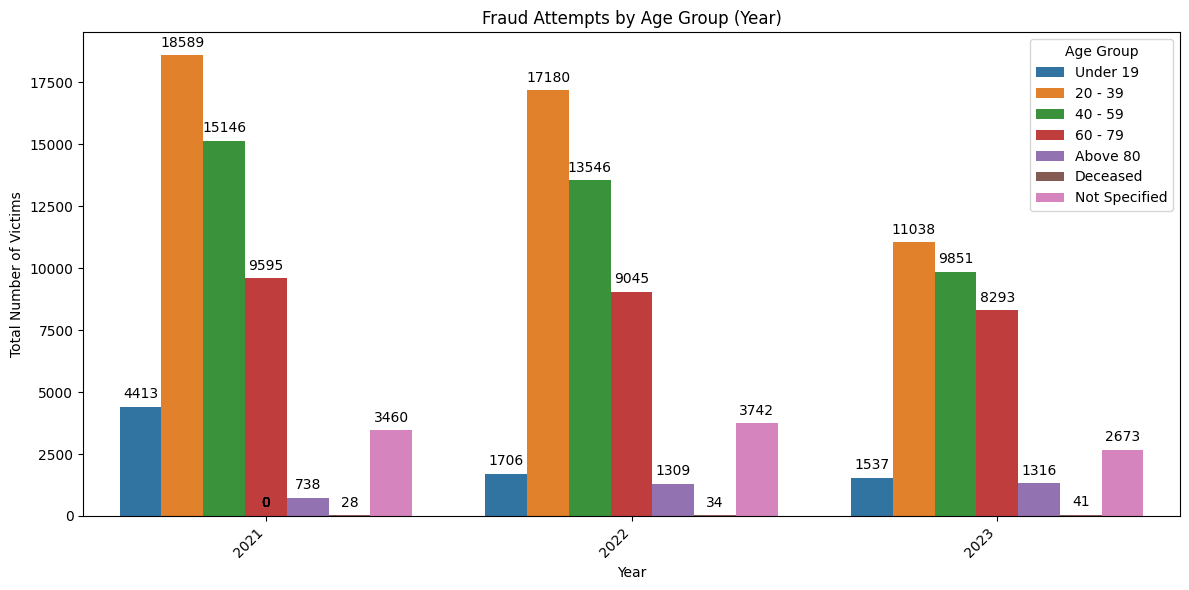

In [ ]:
df_age['Year'] = pd.to_datetime(df_age['Date_Received'], errors='coerce').dt.year
df_age_year_group = df_age.groupby(['Year', 'Victim_Age_Range'], observed=False)['Number_of_Victims'].sum().reset_index()
df_age_year_group = df_age_year_group[df_age_year_group['Year'] != 2024]

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Year', y='Number_of_Victims', hue='Victim_Age_Range', data=df_age_year_group)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.title('Fraud Attempts by Age Group (Year)',fontsize=12)
plt.xlabel('Year')
plt.ylabel('Total Number of Victims')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Age Group', loc='upper right')
plt.show()

Overall, the data shows that fraud attempts are most frequently targeted toward people aged 20 to 39, followed by those aged 40 to 59 across all three years. Although total fraud attempts have been falling over time, young people and middle-aged populations remain the most vulnerable. The aged (60-79 and over 80) face fewer fraud attempts but still account for a large proportion of the total. The "Not Specified" category demonstrates regular gaps in reporting age data, whereas fraud attempts on deceased people are uncommon but exhibit modest year-to-year changes.

### Distribution of Solicitation Methods Across Age Ranges

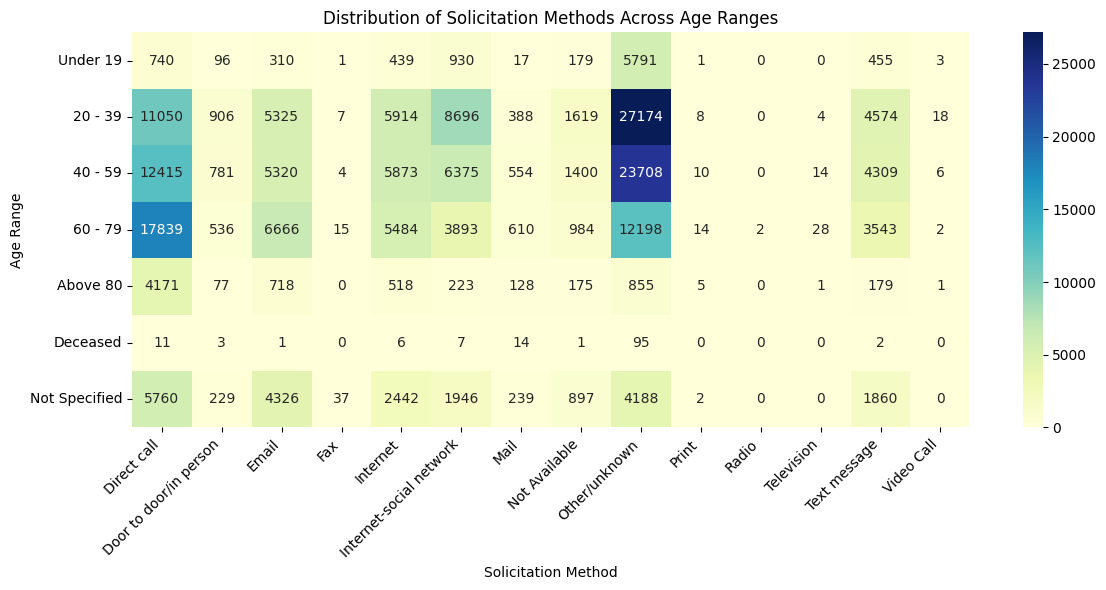

In [ ]:
age_solicitation_method_crosstab = pd.crosstab(df_age['Victim_Age_Range'], df_age['Solicitation Method'])

plt.figure(figsize=(12, 6))
sns.heatmap(age_solicitation_method_crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribution of Solicitation Methods Across Age Ranges',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Age Range')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The heatmap shows clear solicitation trends based on age group. The "20-39" and "40-59" age groups are mostly targeted using the "Internet + Social Network" and "Direct Call" approaches, with "Internet + Social Network" having the highest frequency in the "20-39" range (27,174 instances). The "60-79" age group prefers "Direct Call" as well, however internet-based solicitations are on the decline. Older demographics, such as "Above 80," are less frequently targeted, with mail and traditional techniques being more common.

In addition to displaying relatively high frequencies across age groups, the "Not Available" and "Other/Unknown" categories also likely represent data that could not be correctly gathered or identified. This suggests that these categories may contain important interactions that cannot be directly linked to certain approaches.

To summarize, solicitation tactics are clearly age-dependent, with younger audiences being addressed predominantly through digital means, while older groups continue to be solicited through more traditional channels such as direct calls and letters.

### Distribution of Solicitation Methods Across Age Ranges (Excluding Other/Unknown Methods)

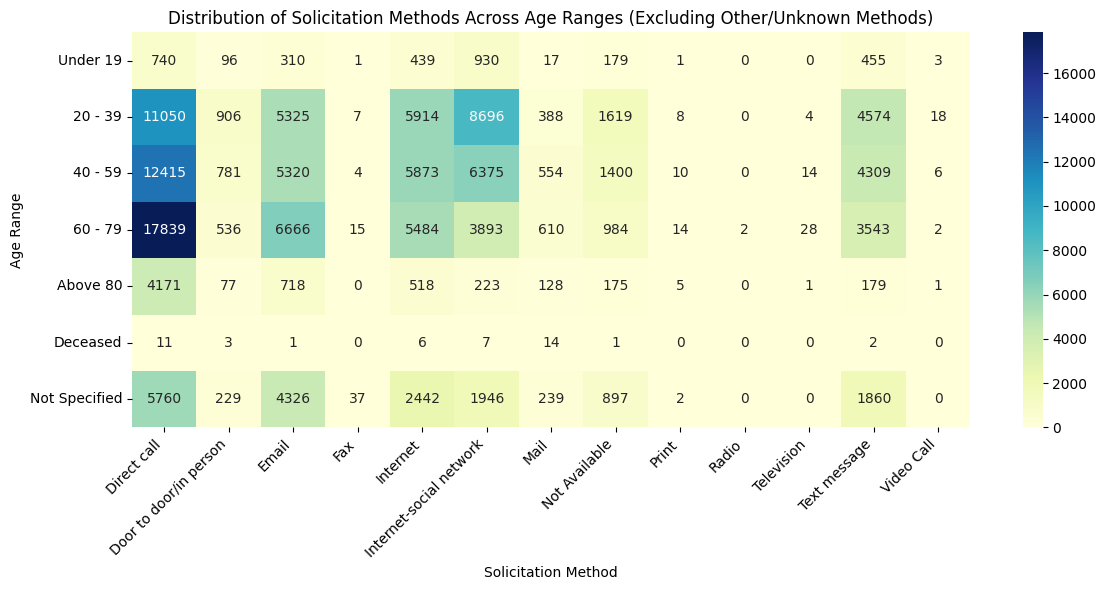

In [ ]:
df_filtered = df_age[df_age['Solicitation Method'] != "Other/unknown"]
age_solicitation_method_crosstab = pd.crosstab(df_filtered['Victim_Age_Range'], df_filtered['Solicitation Method'])

#heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(age_solicitation_method_crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribution of Solicitation Methods Across Age Ranges (Excluding Other/Unknown Methods)',fontsize=12)
plt.xlabel('Solicitation Method')
plt.ylabel('Age Range')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


According to the data, younger groups (under 60) are primarily targeted through both digital and conventional techniques, such as "Internet + Social Network" and "Direct Call." Meanwhile, elderly groups (60+) rely on traditional techniques, particularly "Direct Call" and "Mail." This suggests that focused solicitation techniques should focus on internet outreach for younger audiences and traditional communication for older age groups.


### Trend of Victim Age Ranges Over Years

<Figure size 1200x600 with 0 Axes>

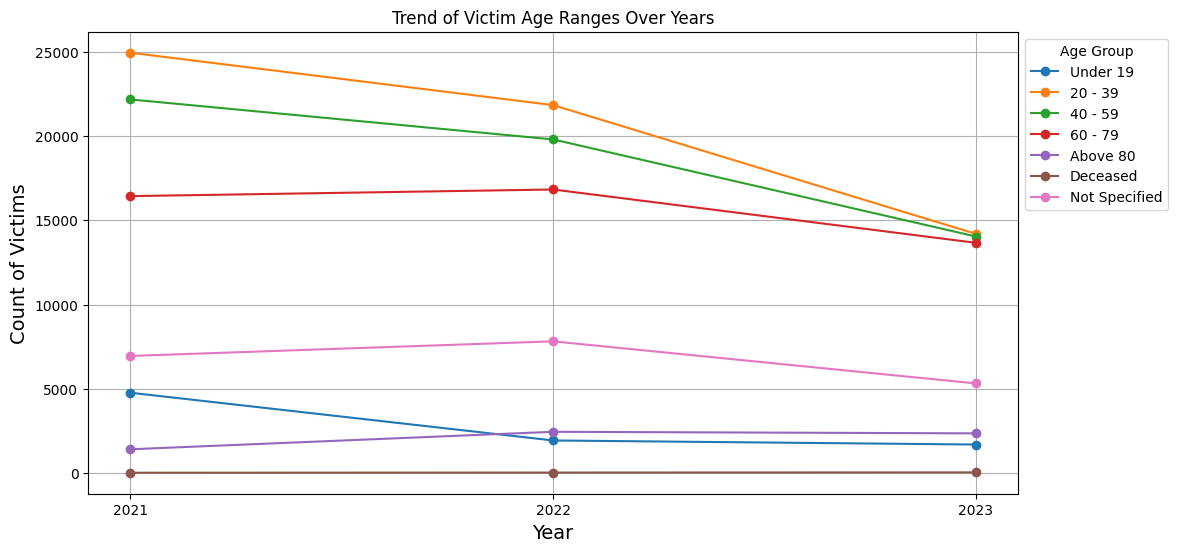

In [ ]:
df_age['Year'] = pd.to_datetime(df_age['Date_Received']).dt.year
age_trend = df_age[df_age['Year'] != 2024].groupby(['Year', 'Victim_Age_Range'], observed=False).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
age_trend.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Trend of Victim Age Ranges Over Years', fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Victims', fontsize=14)
plt.xticks(ticks=age_trend.index, labels=age_trend.index, fontsize=10)
plt.legend(title='Age Group', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.grid()
plt.show()

The graph suggests a consistent and sharp decline in the number of victims across all age groups from 2021 to 2023. The age groups "20-39" and "40-59" saw the most significant reduction, while smaller groups like "Under 19" and "Above 80" maintained relatively lower and steadier numbers. The decline in victim numbers may point to improved safety measures, better preventive actions, or changes in data collection practices over the years. However, the spike in the "Not Specified" category in 2022.


## Conclusion

The investigation of fraud attempts from various age groups revealed differential patterns in victimization and solicitation strategies. Younger age groups, notably those aged 18–34, had a higher frequency of fraud attempts, most likely due to increased online engagement and exposure to digital scams. In contrast, elderly persons (65 and up) reported fewer scam attempts.

---

# GEOGRAPHICAL ANALYSIS

In [55]:
clean_data = data_cleaning_4_raw(data)

canada_data = clean_data.copy()
# Convert 'Date_Received' to datetime if not already done
canada_data.loc[:, 'Date_Received'] = pd.to_datetime(canada_data['Date_Received'], errors='coerce')

# Extreact the year from the 'Date_Received' column using .loc[] to avoid the SettingWithCopyWarning
canada_data.loc[:, 'Year'] = canada_data['Date_Received'].dt.year

# Ensure the 'Number_of_Victims' column is numeric using .loc[] to avoid warnings
canada_data.loc[:, 'Number_of_Victims'] = pd.to_numeric(canada_data['Number_of_Victims'], errors='coerce').fillna(0)

# Ensure 'Dollar_Loss' is numeric by removing special characters (like '$' and ',') and convert it to float
canada_data.loc[:, 'Dollar_Loss'] = canada_data['Dollar_Loss'].replace({r'\$': '', ',': ''}, regex=True).astype(float).fillna(0)

# Group the dataset by 'Province/State' and 'Year', count the number of reports, sum the number_of_victims and dollar_loss
province_year_report_victim_counts = canada_data.groupby(['Province/State', 'Year']).agg(
    Number_of_Reports=('Date_Received', 'size'),  # Counting the number of reports
    Number_of_Victims=('Number_of_Victims', 'sum'),  # Summing the number_of_victims
    Total_Dollar_Loss=('Dollar_Loss', 'sum')  # Summing the dollar_loss
).reset_index()

# Add a new column "% of victimized" = Number_of_Victims / Number_of_Reports
province_year_report_victim_counts['% of Victimized'] = (province_year_report_victim_counts['Number_of_Victims'] /
                                                        province_year_report_victim_counts['Number_of_Reports']) * 100

# Display the result
province_year_report_victim_counts.head()


/var/folders/21/_661td0j1cddth8c88wkc_880000gn/T/ipykernel_99624/348637590.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Province/State,Year,Number_of_Reports,Number_of_Victims,Total_Dollar_Loss,% of Victimized
0,Alberta,2021,7838,5043,30180261.10,64.340393
1,Alberta,2022,7376,4600,52171372.21,62.364425
2,Alberta,2023,5684,3816,63590613.31,67.135820
3,Alberta,2024,1747,1327,23481733.37,75.958786
4,British Columbia,2021,9289,6198,44285557.84,66.724082


### Count "Fraud and Cybercrime Thematic Categories" by province and year

In [56]:
# Create a new DataFrame, counting the number of each type of Fraud and Cybercrime Thematic Category by 'Province/State', 'Year', and 'Fraud_and_Cybercrime_Thematic_Categories'
fraud_category_counts = canada_data.groupby(
    ['Province/State', 'Year', 'Fraud_and_Cybercrime_Thematic_Categories']
).size().reset_index(name='Number_of_Fraud_Categories')

# Sort the DataFrame by 'Province/State' and 'Year' in ascending order, and 'Number_of_Fraud_Categories' in descending order
fraud_category_counts = fraud_category_counts.sort_values(
    by=['Province/State', 'Year', 'Number_of_Fraud_Categories'],
    ascending=[True, True, False]
)

# Display the new DataFrame
fraud_category_counts.head()

,Province/State,Year,Fraud_and_Cybercrime_Thematic_Categories,Number_of_Fraud_Categories
11,Alberta,2021,Identity Fraud,2277
6,Alberta,2021,Extortion,906
18,Alberta,2021,Personal Info,587
24,Alberta,2021,Service,582
19,Alberta,2021,Phishing,556


### Count "Solicitation Method" by province and year

In [57]:
# Create a new DataFrame, counting the number of each type of Solicitation Method by 'Province/State' and 'Year'
solicitation_method_counts = canada_data.groupby(
    ['Province/State', 'Year', 'Solicitation Method']
).size().reset_index(name='Number_of_Solicitation_Methods')

# Sort the DataFrame by 'Province/State' and 'Year' in ascending order, and 'Number_of_Solicitation_Methods' in descending order
solicitation_method_counts = solicitation_method_counts.sort_values(
    by=['Province/State', 'Year', 'Number_of_Solicitation_Methods'],
    ascending=[True, True, False]
)

# Display the new DataFrame
solicitation_method_counts.head()


,Province/State,Year,Solicitation Method,Number_of_Solicitation_Methods
8,Alberta,2021,Other/unknown,2651
0,Alberta,2021,Direct call,2056
4,Alberta,2021,Internet,792
2,Alberta,2021,Email,767
5,Alberta,2021,Internet-social network,681


### Data Visualization

#### Horizontal bar chart to show the number of reports grouped by province for each year

In [58]:
# Get the unique years from the dataset and rename 2024 to '2024 (H1)'
years = sorted(province_year_report_victim_counts['Year'].unique())
year_labels = {year: f'{year}' for year in years}  # Create a label mapping
year_labels[2024] = '2024 (H1)'  # Rename 2024 to '2024 (H1)'

# Determine the maximum number of reports for consistent x-axis limits
max_reports = province_year_report_victim_counts['Number_of_Reports'].max()

# Loop through each year and create a horizontal bar chart
for year in years:
    # Filter data for the current year
    data_by_year = province_year_report_victim_counts[province_year_report_victim_counts['Year'] == year]

    # Sort data by 'Number_of_Reports' in descending order
    data_by_year = data_by_year.sort_values(by='Number_of_Reports', ascending=True)  # Ascending for horizontal bars

    # Create the horizontal bar chart for the year
    fig = px.bar(data_by_year,
                 y='Province/State',  # Provinces on y-axis
                 x='Number_of_Reports',  # Reports on x-axis
                 orientation='h',  # Horizontal chart
                 title=f'Number of Reports by Province in {year_labels[year]}',
                 labels={'Number_of_Reports': 'Number of Reports', 'Province/State': 'Province'},
                 color='Number_of_Reports',  # Use continuous color scale
                 color_continuous_scale='Reds')  # Red gradient color scale

    # Set consistent x-axis limits across all charts
    fig.update_layout(xaxis=dict(range=[0, max_reports]))

    # Reverse the y-axis to show largest values at the top
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})

    # Display the chart
    fig.show()


## Conlcusion

---

# FINANCIAL LOSS ANALYSIS

In [59]:
clean_data = data_cleaning_4_raw(data)

/var/folders/21/_661td0j1cddth8c88wkc_880000gn/T/ipykernel_99624/348637590.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
clean_data['Complaint Type'].unique()

array(['Attempt', 'Victim', 'Other', 'Unknown', 'Incomplete'],
      dtype=object)

In [61]:
print(clean_data['Dollar_Loss'].describe())

count    2.163450e+05
mean     6.317350e+03
std      1.007662e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.361500e+07
Name: Dollar_Loss, dtype: float64


## Fianacial Analysis

In [62]:
gender_loss = clean_data.groupby('Gender')['Dollar_Loss'].mean().reset_index()
print(gender_loss)

              Gender   Dollar_Loss
0             Female   4599.584650
1               Male   6253.400837
2      Not Available  14758.530669
3              Other   1533.931863
4  Prefer not to say   2258.122010
5            Unknown   7273.398565


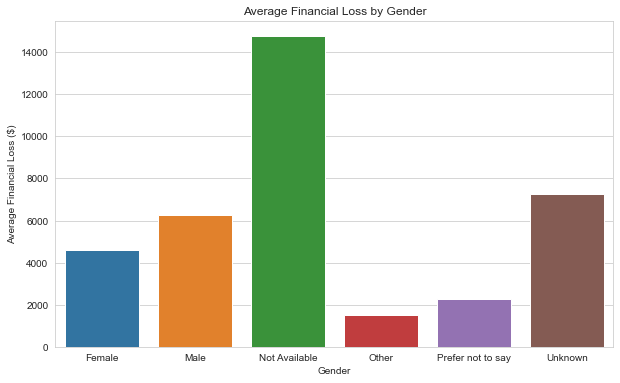

In [63]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Gender', y='Dollar_Loss', data=gender_loss)
plt.title('Average Financial Loss by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Financial Loss ($)')
plt.show()

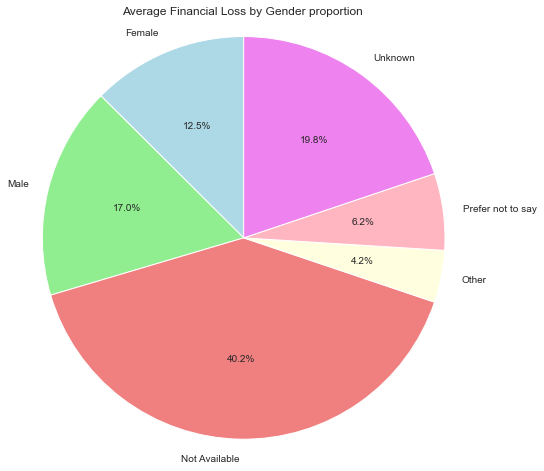

In [64]:

# Prepare data for the pie chart
labels = gender_loss['Gender']
sizes = gender_loss['Dollar_Loss']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral','lightyellow','lightpink','violet'])
plt.title('Average Financial Loss by Gender proportion')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

From the above finding, The proportion of male is more compared to other genders. Also the dollar loss is more for male, 6253 dollars on an average.

## Province Analysis

In [65]:
province_id= clean_data['Province/State'].unique()

In [66]:
province_loss = clean_data.groupby('Province/State')['Dollar_Loss'].mean().reset_index().sort_values(by='Dollar_Loss',ascending=False)
province_loss

,Province/State,Dollar_Loss
1,British Columbia,8705.023650
9,Ontario,8103.913469
2,Manitoba,7750.831276
0,Alberta,7481.739015
5,North West Territories,6192.531242
8,Nunavut,6078.672289
12,Saskatchewan,5714.541442
4,Newfoundland And Labrador,4478.600804
6,Not Specified,4473.498767
3,New Brunswick,4187.285279


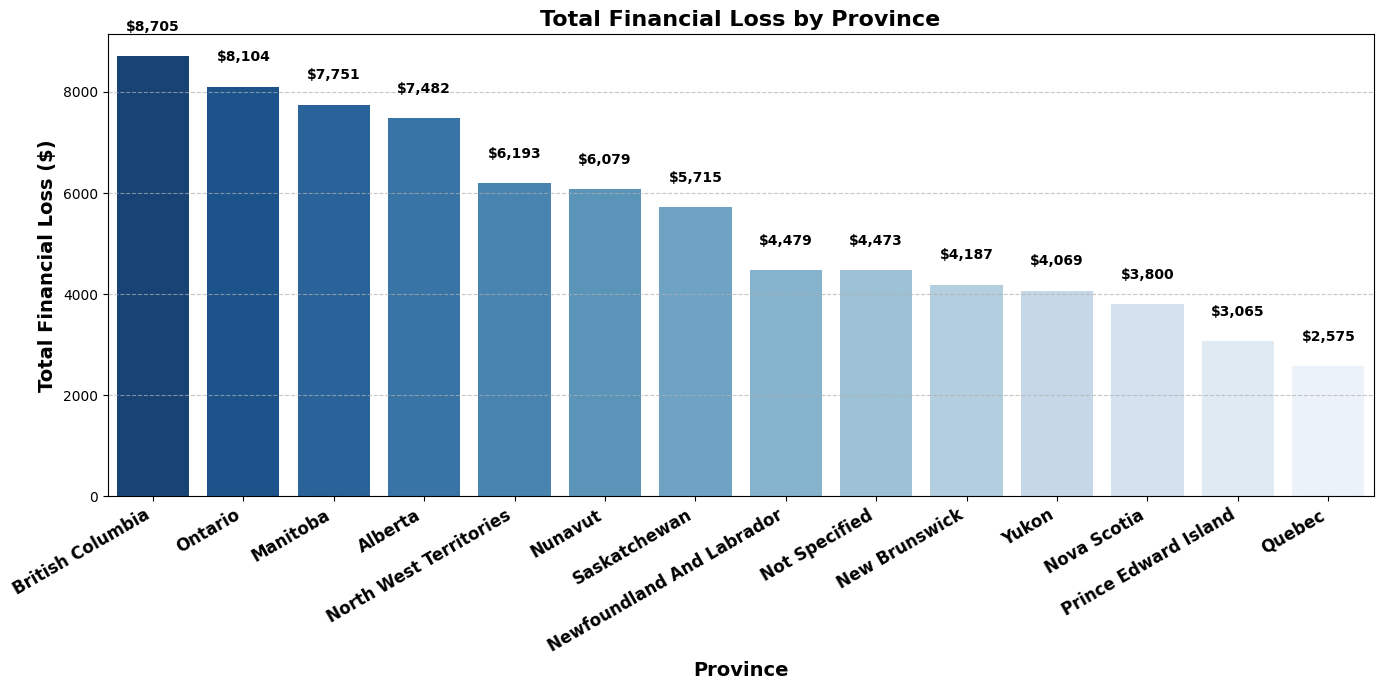

In [14]:

plt.figure(figsize=(14, 7))

palette = sns.color_palette("Blues_r", len(province_loss))

sns.barplot(x='Province/State', y='Dollar_Loss', hue='Province/State', data=province_loss, palette=palette, dodge=False)
plt.legend([],[], frameon=False)

plt.title('Total Financial Loss by Province', fontsize=16, fontweight='bold')
plt.xlabel('Province', fontsize=14, fontweight='bold')
plt.ylabel('Total Financial Loss ($)', fontsize=14, fontweight='bold')


plt.xticks(rotation=30, ha='right', fontsize=12, fontweight='bold')


plt.gca().patch.set_facecolor('white')
bars = plt.gca().patches
for bar in bars:
    bar.set_width(0.8)

for index, value in enumerate(province_loss['Dollar_Loss']):
    plt.text(index, value + 500, f'${value:,.0f}', ha='center', fontsize=10, color='black', fontweight='bold')


plt.grid(True, axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()

plt.show()




From the above findings, on an average, the british columbia, is the one who is highly affected while the surprising thing is quebec which has lowest although they have many industry and a big population.

## Age Range Analysis

In [15]:
age_range= clean_data['Victim_Age_Range'].unique()
age_range

array(["'Not Available / non disponible", "'40 - 49", "'30 - 39",
       "'60 - 69", "'70 - 79", "'10 - 19", "'20 - 29", "'50 - 59",
       "'80 - 89", "'1 - 9", "'Deceased / Décédé", "'90 - 99", "'100 +",
       "'Business / Entreprise"], dtype=object)

In [16]:
age_range_id = clean_data.groupby('Victim_Age_Range')['Dollar_Loss'].mean().reset_index()
age_range_id

,Victim_Age_Range,Dollar_Loss
0,'1 - 9,1302.578562
1,'10 - 19,625.572225
2,'100 +,1925.905192
3,'20 - 29,1750.199283
4,'30 - 39,3067.813363
5,'40 - 49,5815.443867
6,'50 - 59,8434.209976
7,'60 - 69,8162.885312
8,'70 - 79,7647.480442
9,'80 - 89,5783.455192


In [17]:

unwanted_categories = [
    "'1 - 9",
    "'Business / Entreprise",
    "'Deceased / Décédé",

]

# Filter out unwanted categories using multiple conditions
filtered_age_range = age_range_id[
    ~age_range_id['Victim_Age_Range'].isin(unwanted_categories)
]
filtered_age_range

#filter the data

,Victim_Age_Range,Dollar_Loss
1,'10 - 19,625.572225
2,'100 +,1925.905192
3,'20 - 29,1750.199283
4,'30 - 39,3067.813363
5,'40 - 49,5815.443867
6,'50 - 59,8434.209976
7,'60 - 69,8162.885312
8,'70 - 79,7647.480442
9,'80 - 89,5783.455192
10,'90 - 99,3404.891505


In [18]:
import plotly.express as px

fig = px.bar(
    filtered_age_range,
    x='Victim_Age_Range',
    y='Dollar_Loss',
    title='Distribution of Financial Loss by Victim Age Range',
    labels={'Victim_Age_Range': 'Victim Age Range', 'Dollar_Loss': 'Financial Loss ($)'},
    text='Dollar_Loss'
)


fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title='Victim Age Range',
    yaxis_title='Financial Loss ($)',
    xaxis_tickangle=-45,
    template='plotly_white'
)
fig.update_layout(
    width=800,  # Set the width of the plot
    height=600,  # Set the height of the plot

)

fig.show()

From the above findings, we can see for age 50-59 on an average each person loss is appor 8500 dollars, which was expected as they may have less
knowledge about the current scams going on.

## Conlcusion
The analysis revealed that while males were initially more affected by fraud attempts and victimization, females surpassed them in both metrics by 2022. However, the differences between the two gender groups were not substantial, indicating that fraud impacts both genders similarly. Identity fraud was the most common type of fraud for all genders, with tech support scams and online shopping fraud also prominent. The overall downward trend in both fraud attempts and victimization suggests that fraud prevention measures may be improving over time.